# 讽刺数据集的词嵌入、分类与可视化

In [11]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [13]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
#     -O /tmp/sarcasm.json


In [25]:
with open("./tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [26]:
# 分训练集和测试集
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [27]:
# 生成词典
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# 序列化
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length
                                , padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length
                               , padding=padding_type, truncating=trunc_type)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 24)                408       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [30]:
num_epochs = 30
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [31]:
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - loss: 0.6583 - accuracy: 0.5983 - val_loss: 0.5538 - val_accuracy: 0.7915 - 4s/epoch - 7ms/step
Epoch 2/30
625/625 - 3s - loss: 0.4145 - accuracy: 0.8356 - val_loss: 0.3884 - val_accuracy: 0.8275 - 3s/epoch - 6ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3042 - accuracy: 0.8792 - val_loss: 0.3541 - val_accuracy: 0.8477 - 2s/epoch - 4ms/step
Epoch 4/30
625/625 - 2s - loss: 0.2523 - accuracy: 0.9018 - val_loss: 0.3460 - val_accuracy: 0.8515 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2169 - accuracy: 0.9160 - val_loss: 0.3453 - val_accuracy: 0.8574 - 2s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1917 - accuracy: 0.9269 - val_loss: 0.3585 - val_accuracy: 0.8498 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1679 - accuracy: 0.9378 - val_loss: 0.3736 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.1494 - accuracy: 0.9456 - val_loss: 0.4055 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

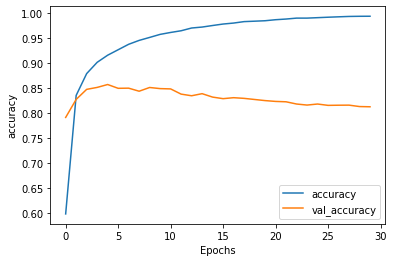

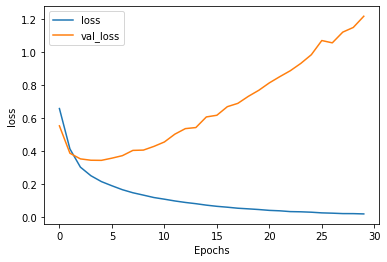

In [32]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

发生了过拟合，需要调整超参数来限制过拟合（例如：缩小词典的词汇量，将句子的最大长度缩短，增大嵌入层数量等）

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

# 用不同网络对讽刺数据集进行分类

验证准确率发生下降，说明出现过拟合。文本处理更容易出现过拟合，因为验证数据集中总是容易出现未登陆词，需要在训练中采取过拟合处理办法。

- 单层GRU

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)), # 换成一个LSTM，，大约20s/epoch
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 46s - loss: 0.4712 - accuracy: 0.7732 - val_loss: 0.3398 - val_accuracy: 0.8539 - 46s/epoch - 74ms/step
Epoch 2/30
625/625 - 50s - loss: 0.2322 - accuracy: 0.9061 - val_loss: 0.3523 - val_accuracy: 0.8493 - 50s/epoch - 80ms/step
Epoch 3/30
625/625 - 45s - loss: 0.1637 - accuracy: 0.9380 - val_loss: 0.3899 - val_accuracy: 0.8518 - 45s/epoch - 71ms/step
Epoch 4/30
625/625 - 57s - loss: 0.1222 - accuracy: 0.9571 - val_loss: 0.4444 - val_accuracy: 0.8448 - 57s/epoch - 92ms/step
Epoch 5/30
625/625 - 49s - loss: 0.0909 - accuracy: 0.9691 - val_loss: 0.4806 - val_accuracy: 0.8438 - 49s/epoch - 78ms/step
Epoch 6/30


KeyboardInterrupt: 

- 单层LSTM+池化

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 换成一个GRU，大约50s/epoch
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

- 卷积+池化

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128,5,activation='relu'), # 换成一个卷积层，大约10s/epoch
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 15s - loss: 0.5255 - accuracy: 0.7208 - val_loss: 0.4053 - val_accuracy: 0.8179 - 15s/epoch - 23ms/step
Epoch 2/30
625/625 - 14s - loss: 0.2981 - accuracy: 0.8746 - val_loss: 0.3716 - val_accuracy: 0.8374 - 14s/epoch - 23ms/step
Epoch 3/30
625/625 - 8s - loss: 0.2107 - accuracy: 0.9168 - val_loss: 0.4096 - val_accuracy: 0.8305 - 8s/epoch - 13ms/step
Epoch 4/30
625/625 - 8s - loss: 0.1603 - accuracy: 0.9401 - val_loss: 0.4273 - val_accuracy: 0.8389 - 8s/epoch - 13ms/step
Epoch 5/30
625/625 - 8s - loss: 0.1229 - accuracy: 0.9556 - val_loss: 0.4911 - val_accuracy: 0.8311 - 8s/epoch - 13ms/step
Epoch 6/30
625/625 - 11s - loss: 0.0944 - accuracy: 0.9684 - val_loss: 0.5424 - val_accuracy: 0.8299 - 11s/epoch - 17ms/step
Epoch 7/30
625/625 - 18s - loss: 0.0719 - accuracy: 0.9760 - val_loss: 0.6179 - val_accuracy: 0.8237 - 18s/epoch - 28ms/step
Epoch 8/30
625/625 - 10s - loss: 0.0511 - accuracy: 0.9849 - val_loss: 0.6805 - val_accuracy: 0.8238 - 10s/epoch - 16ms/step
Epoch 

KeyboardInterrupt: 

- 多层LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")